In [1]:
import argparse
import pathlib
import random
from collections import deque
from typing import List, Dict, Tuple, Union
from data import Dataset
from data_utils import *
from sampling import *
from models import BetaBernoulli
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from utils import mean_reciprocal_rank
%matplotlib inline  

import matplotlib;matplotlib.rcParams['font.size'] = 10
import matplotlib;matplotlib.rcParams['font.family'] = 'serif'
LINEWIDTH = 13.97

LOG_FREQ = 10
RUNS = 100
method_list = ['random_arm', 'random_data', 'ts_uniform', 'ts_informed']
method_format = {'random_arm': ('Random Arm', 'b', '.', '-.'), 
                 'random_data': ('Random Datapoint', 'g', '^', '-.'), 
                 'ts_uniform': ('TS Uniform', 'r', '*', '-'), 
                 'ts_informed': ('TS informed', 'r', '+', '-.'),
                }
DATASET_LIST = ['cifar100', 'dbpedia', '20newsgroup', 'svhn'] #'imagenet', 

In [2]:
metric = 'most_accurate'
group_method = 'predicted_class'
pseudocount = 2
output = pathlib.Path("../output/%s/" % metric )

In [3]:
# load results and compute ground truth
samples = {}
mpe_log = {}
ground_truth = {}
weight_k = {}

for dataset_name in tqdm(DATASET_LIST): # takes 4 minutes to load results of imagenet
    experiment_name = '%s_groupby_%s_pseudocount%.2f' %  (dataset_name, group_method, pseudocount)
    samples[dataset_name] = {}
    mpe_log[dataset_name] = {}
    ground_truth[dataset_name] = {}
    # load data
    dataset = Dataset.load_from_text(dataset_name)
    dataset.group(group_method = group_method)
    # ground truth
    ground_truth[dataset_name]['accuracy_k'] = dataset.accuracy_k
    ground_truth[dataset_name]['accuracy_k'][np.isnan(ground_truth[dataset_name]['accuracy_k'])] = 0
    ground_truth[dataset_name]['least_accurate'] = np.argmin(dataset.accuracy_k)
    ground_truth[dataset_name]['most_accurate'] = np.argmax(dataset.accuracy_k)
    weight_k[dataset_name] = dataset.weight_k
    # load results
    for method_name in method_list:
        samples[dataset_name][method_name] = np.load(open(\
                                output / experiment_name / ('samples_%s.npy' % method_name), 'rb'))
        mpe_log[dataset_name][method_name] = np.load(open(\
                                output / experiment_name / ('mpe_log_%s.npy' % method_name), 'rb'))

100%|██████████| 4/4 [00:04<00:00,  1.02s/it]


# $L_2$

In [4]:
# eval
l2_error = {}
for dataset_name in DATASET_LIST:
    print(dataset_name)
    l2_error[dataset_name] = {}
    for method_name in method_list:
        # mpe_log[dataset_name][method]: (RUNS, dataset.__len__() // LOG_FREQ, dataset.num_groups)
        error = mpe_log[dataset_name][method_name]-ground_truth[dataset_name]['accuracy_k'][np.newaxis,np.newaxis,:]
        l2_error[dataset_name][method_name] = np.sqrt(np.inner((error)**2, weight_k[dataset_name]))
# dump results

cifar100
dbpedia
20newsgroup
svhn


Text(0, 0.5, '$L_2$ Error')

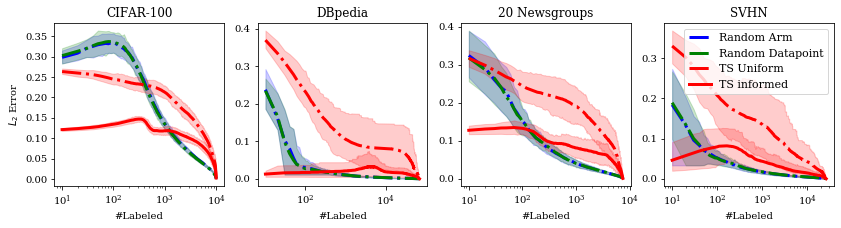

In [5]:
# plot
method_format = {'random_arm': ('Random Arm', 'b', '.', '-.'), 
                 'random_data': ('Random Datapoint', 'g', '^', '-.'), 
                 'ts_uniform': ('TS Uniform', 'r', '*', '-.'), 
                 'ts_informed': ('TS informed', 'r', '+', '-'),
                }
fig, axes = plt.subplots(nrows=1, ncols=len(DATASET_LIST), figsize=(LINEWIDTH,3),
                        gridspec_kw = {'wspace':0.2, 'hspace':0.25})
for i, dataset_name in enumerate(DATASET_LIST):
    start = 1
    num_steps = l2_error[dataset_name][method_name].shape[1] - 1
    stepsize = 1
    for method_name in method_format:
        legend_name, color, marker, linestyle = method_format[method_name]    
        xrange = np.arange(num_steps) * LOG_FREQ
        idx = np.arange(num_steps)[start:(start+num_steps)][::stepsize]   
        axes[i].plot(xrange[idx], 
                 np.mean(l2_error[dataset_name][method_name], axis=0)[idx], 
                 label=legend_name, linewidth=3, color=color, linestyle=linestyle)
        axes[i].fill_between(xrange[idx], 
                         np.quantile(l2_error[dataset_name][method_name], 0.125, axis=0)[idx], 
                         np.quantile(l2_error[dataset_name][method_name], 0.875, axis=0)[idx], 
                         color=color, alpha=.2)
        #plt.ylim([0, 0.3])
    axes[i].set_xlabel('#Labeled')
    axes[i].set_xscale('log')
    axes[i].set_title(DATASET_NAMES[dataset_name])
axes[-1].legend(fontsize=11, loc='upper right')
axes[0].set_ylabel('$L_2$ Error')

In [6]:
fig.savefig('../figures/groupwise_l2_%s_%s_pseudocount%.2f.pdf' % (metric, group_method, pseudocount), \
            dpi=300, bbox_inches='tight', pad_inches=0)

# MRR

In [7]:
def eval_topk(mpe_log: np.ndarray, ground_truth: list, topk: int = 1) -> Dict[str, np.ndarray]:
    """
    Top k greatest
    :param mpe_log:(num_runs, num_samples // LOG_FREQ, num_classes)
    :param ground_truth: list of integers of length topk. Ground truth of topk classes.
    :param topk: int
    """
    assert len(ground_truth) == topk
    num_runs, num_evals, num_classes = mpe_log.shape
    avg_num_agreement = [None] * num_evals
    mrr = [None] * num_evals

    ground_truth_array = np.zeros((num_classes,), dtype=np.bool_)
    ground_truth_array[np.array(ground_truth).astype(int)] = 1

    for idx in range(num_evals):
        current_result = mpe_log[:, idx, :]
        topk_arms = np.argsort(current_result, axis=-1)[:, -topk:]
        topk_list = topk_arms.flatten().tolist()
        avg_num_agreement[idx] = len([arm for arm in topk_list if arm in ground_truth]) * 1.0 / (
                topk * num_runs)
        mrr[idx] = [mean_reciprocal_rank(mpe_log[run_id, idx, :], ground_truth_array, 'max') for run_id in
                        range(num_runs)]
    return {
        'avg_num_agreement': avg_num_agreement,
        'mrr': np.array(mrr),
    }

In [8]:
avg_num_agreement = {}
mrr = {}
for dataset_name in tqdm(DATASET_LIST):
    avg_num_agreement[dataset_name] = {}
    mrr[dataset_name] = {}
    for method_name in method_list:
        if metric  == 'least_accurate':
            eval_topk_output = eval_topk(-mpe_log[dataset_name][method_name],
                                        [ground_truth[dataset_name][metric]])
        elif metric == 'most_accurate':
            eval_topk_output = eval_topk(mpe_log[dataset_name][method_name],
                                        [ground_truth[dataset_name][metric]])
        avg_num_agreement[dataset_name][method_name] = eval_topk_output['avg_num_agreement'] # num_samples // LOG_FREQ
        mrr[dataset_name][method_name] = eval_topk_output['mrr'] # num_runs, num_samples // LOG_FREQ

100%|██████████| 4/4 [02:59<00:00, 44.86s/it]


Text(0, 0.5, '$MRR')

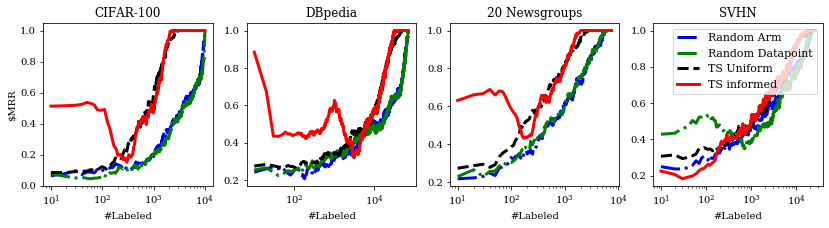

In [9]:
# plot
method_format = {'random_arm': ('Random Arm', 'b', '.', '-.'), 
                 'random_data': ('Random Datapoint', 'g', '^', '-.'), 
                 'ts_uniform': ('TS Uniform', 'k', '*', '--'), 
                 'ts_informed': ('TS informed', 'r', '+', '-'),
                }
fig, axes = plt.subplots(nrows=1, ncols=len(DATASET_LIST), figsize=(LINEWIDTH,3),
                        gridspec_kw = {'wspace':0.2, 'hspace':0.25})
for i, dataset_name in enumerate(DATASET_LIST):
    start = 1
    mrr[dataset_name][method_name] = np.array(mrr[dataset_name][method_name])
    num_steps = mrr[dataset_name][method_name].shape[0] - start
    stepsize = 1
    for method_name in method_format:
        legend_name, color, marker, linestyle = method_format[method_name]    
        xrange = np.arange(num_steps) * LOG_FREQ
        idx = np.arange(num_steps)[start:(start+num_steps)][::stepsize]   
        axes[i].plot(xrange[idx], 
                     np.mean(mrr[dataset_name][method_name], axis=1)[idx], 
                     label=legend_name, linewidth=3, color=color, linestyle=linestyle)
#         axes[i].fill_between(xrange[idx], 
#                          np.quantile(mrr[dataset_name][method_name], 0.125, axis=1)[idx], 
#                          np.quantile(mrr[dataset_name][method_name], 0.875, axis=1)[idx], 
#                          color=color, alpha=.2)
        #plt.ylim([0, 0.3])
    axes[i].set_xlabel('#Labeled')
    axes[i].set_xscale('log')
    axes[i].set_title(DATASET_NAMES[dataset_name])
axes[-1].legend(fontsize=11, loc='upper right')
axes[0].set_ylabel('$MRR')

In [10]:
fig.savefig('../figures/l2_%s_%s_pseudocount%.2f.pdf' % (metric, group_method, pseudocount), \
            dpi=300, bbox_inches='tight', pad_inches=0)